In [ ]:
# !pip install --upgrade xgboost
# !pip install s3fs
# !pip install --upgrade pandas
# !pip install --upgrade fsspec
# ! pip install lightgbm
!pip install --upgrade scikit-multilearn
!pip install arff

     |████████████████████████████████| 92kB 5.0MB/s 
  Created wheel for arff: filename=arff-0.9-cp37-none-any.whl size=4970 sha256=1e780bd9cd97a74117991e652f921e2c93707c5289bb41855514a44ba0f2aae9
  Stored in directory: /root/.cache/pip/wheels/04/d0/70/2c73afedd3ac25c6085b528742c69b9587cbdfa67e5194583b
Successfully built arff


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from skmultilearn.adapt import MLkNN
import h5py
import arff
from itertools import islice
import numpy as np 
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree, BallTree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import jaccard_score
import pickle
from itertools import product
import time
from multiprocessing import Pool

# model_path = "/content/drive/MyDrive/Colab Notebooks/Metrics Learning/models"
model_path = "metrics_learning"

In [ ]:
from skmultilearn.dataset import available_data_sets
from skmultilearn.dataset import load_dataset

Xtrain, ytrain, feature_names, label_names = load_dataset('yeast', 'train')
Xtest, ytest, feature_names, label_names = load_dataset('yeast', 'test')

print(label_names)
data_train = Xtrain.toarray()
data_test = Xtest.toarray()

labels_train = ytrain.toarray()
labels_test = ytest.toarray()

print(data_train.shape, type(data_train))
print(data_test.shape, type(data_test))



yeast:train - does not exists downloading
Downloaded yeast-train
yeast:test - does not exists downloading
Downloaded yeast-test
[('Class1', ['0', '1']), ('Class2', ['0', '1']), ('Class3', ['0', '1']), ('Class4', ['0', '1']), ('Class5', ['0', '1']), ('Class6', ['0', '1']), ('Class7', ['0', '1']), ('Class8', ['0', '1']), ('Class9', ['0', '1']), ('Class10', ['0', '1']), ('Class11', ['0', '1']), ('Class12', ['0', '1']), ('Class13', ['0', '1']), ('Class14', ['0', '1'])]
(1500, 103) <class 'numpy.ndarray'>
(917, 103) <class 'numpy.ndarray'>


In [ ]:

def saveLocal(obj, path): 
    allparents = []
    p = os.path.dirname(path)
    while p: 
        allparents.append(p)
        p = os.path.dirname(p)
        
#     print(allparents)
    for p in allparents[::-1]: 
        try: 
            os.mkdir(p)
        except: 
            continue
            
    pickle.dump(obj, open(path, 'wb'))

def loadPickle(key): 
    return pickle.load(open(key, 'rb'))

def convertX(X, split): 
    global XIterPostScaler, iteration
    GMAT = loadPickle('%s/iteration%d/GMAT.pkl'%(model_path, iteration))
    X = np.dot(X, GMAT.T)
    if split == "save": 
        XIterPostScaler = StandardScaler()
        XIterPostScaler.fit(X)
        key =  '%s/iteration%d/XIterPostScaler.pkl'%(model_path, iteration)
        saveLocal(XIterPostScaler, key)
    else: 
        key = '%s/iteration%d/XIterPostScaler.pkl'%(model_path, iteration)
        XIterPostScaler = pickle.load(open(key, 'rb'))
        
    X = XIterPostScaler.transform(X)
    return X


In [ ]:
iteration = 0
# arr = list((list(a) for a in arff.load('enron/yeast.arff')))
# arr = np.array(arr).astype('float32')
# data_train, data_test, labels_train, labels_test = train_test_split(arr[:, :-14], arr[:, -14:], test_size=0.20, random_state=42)

# print(data_train.shape, data_test.shape, labels_train.shape, labels_test.shape)

# saveLocal(data_train, 'data/data_train.pkl')
# saveLocal(data_test, 'data/data_test.pkl')
# saveLocal(labels_train, 'data/labels_train.pkl')
# saveLocal(labels_test, 'data/labels_test.pkl')

mu = 0
num_features = data_train.shape[1]
m_Dimensions = num_features
sigma = 1/(m_Dimensions + num_features)

GMAT = np.identity(num_features)# + np.random.normal(mu, sigma, (m_Dimensions, num_features))
saveLocal(GMAT, '%s/iteration%d/GMAT.pkl'%(model_path, iteration))

batch_size = 128
num_features = data_train.shape[1]


parameters = {'k': range(1,10), 's': [0.5, 0.7, 1.0]}
# score = 'f1_macro'

# clf = GridSearchCV(MLkNN(), parameters, scoring=score)
# clf.fit(data_train, labels_train)

# print (clf.best_params_, clf.best_score_)

classifier = MLkNN(k=10, s = 0.5)
classifier.fit(data_train, labels_train)
mlknn_preds = classifier.predict(data_test).toarray()

# print(labels_test.mean(0))
# print(preds.mean(0))

# print(np.sum(labels_test), np.sum(preds), preds.shape[0]*preds.shape[1])
# print("logical or:", np.sum(np.logical_or(labels_test, preds)))
# print("logical xor:", np.sum(np.logical_xor(labels_test, preds)))
# print("logical and:", np.sum(np.logical_and(labels_test, preds)))

# logical_and = np.sum(np.logical_and(labels_test, preds))
# logical_or  = np.sum(np.logical_or(labels_test, preds))

# print("Accuracy of labels:", logical_and/logical_or)

In [ ]:

def trainKDT(X): 
    global iteration
#     X = getPickle('etan/PGP/DATA/%s/X%s.pkl'%(KNNDIR, str(i).zfill(2)))
#     Xi = np.dot(X[BASES[i]:BASES[i+1], :], GMAT.T)
    X = convertX(X, 'save')
#     print(Xi.shape)
    tree = KDTree(X)
    key =  '%s/iteration%d/kdtree.pkl'%(model_path, iteration)
#     savePickle(tree, key)
    saveLocal(tree, key)
    print("saved:", key)
    

def saveKNN(X, split = "train"): 
    global iteration
    K = 100
    key =  '%s/iteration%d/kdtree.pkl'%(model_path, iteration)
    KDT = loadPickle(key)
    
#     PIDS = getPickle('etan/PGP/DATA/%s/PIDS%s.pkl'%("KNN", str(i).zfill(2))).ravel()
    neighbors = np.zeros((X.shape[0], K)) - 1
    distances = np.zeros((X.shape[0], K)) - 1
    X = convertX(X, None)
    dist, nl = KDT.query(X,100)
    print(dist.shape, nl.shape)
    saveLocal(dist, '%s/iteration%d/distances_%s.pkl'%(model_path, iteration, split))

    saveLocal(nl, '%s/iteration%d/neighbors_%s.pkl'%(model_path, iteration, split))
    
trainKDT(data_train)
saveKNN(data_train)
saveKNN(data_test, split = "test")

saved: metrics_learning/iteration0/kdtree.pkl
(1500, 100) (1500, 100)
(917, 100) (917, 100)


In [ ]:
def stepDist(tup): 
    xi, xj, yi, yj = tup
    loss_score_list = np.array([1 - np.sum(np.logical_and(yi, yj))/len(yi),
                          1 - np.sum(np.logical_or(yi, yj))/len(yi),
                          np.sum(np.logical_xor(yi, yj))/len(yi)
                        ])
    return np.concatenate([xi, xj, loss_score_list])

def genQuery(X, Y, neighbors, coordinates):
    for v, w in coordinates: 
        if v == neighbors[v][w]: 
            continue
        yield [X[v], X[neighbors[v][w]], Y[v], Y[neighbors[v][w]]]

def saveDistanceData(X, Y):
    global iteration
    K = 100
    N = min(1000000, X.shape[0]*K)
    DistMat = np.zeros((N, 3 + 2*X.shape[1]))

    neighbors = pickle.load(open('%s/iteration%d/neighbors_%s.pkl'%(model_path, iteration, 'train'), 'rb'))
    coordinates = list(product(range(neighbors.shape[0]), range(neighbors.shape[1])))
    np.random.shuffle(coordinates)
    tuplist = islice(genQuery(X, Y, neighbors, coordinates), N)
    t0 = time.time()
    pool = Pool()
    for j, row in enumerate(pool.imap(stepDist, tuplist)):
        if row is None: 
            continue 
#             print(row)
        DistMat[j] = row
        if j%(N//5) == N//5 - 1: 
            t1 = time.time()
            r = N - j - 1
            print("Label Distance Time & ETA:",  round((t1-t0)/60, 2),(r/N*((t1 - t0)/60)))

    DistMat = DistMat[~np.all(DistMat == 0, axis=1)]
    pool.close()
    pool.join()
#         print(JMAT[np.random.choice(JMAT.shape[0], 20), :])
#     print("Label Distancew Mean:", np.round(DistMat.mean(0),2))
    key = '%s/iteration%d/label_distances.pkl'%(model_path, iteration) #'etan/PGP/DATA/%s/JMAT/Iter%d/JMAT%s.pkl'%(KNNDIR, iteration, str(i).zfill(2))
    saveLocal(DistMat, key)
    print("SAVED:", DistMat.shape, key)
    
saveDistanceData(data_train, labels_train)

Label Distance Time & ETA: 0.1 0.07876074473063152
Label Distance Time & ETA: 0.2 0.11784132242202759
Label Distance Time & ETA: 0.29 0.1178205140431722
Label Distance Time & ETA: 0.39 0.07848560651143392
SAVED: (148500, 209) metrics_learning/iteration0/label_distances.pkl


In [ ]:
!pwd
!ls
!cp metrics_learning drive/MyDrive/COLAB/ --recursive
# !sync drive/MyDrive/COLAB/metrics_learning metrics_learning

/content
drive  metrics_learning  sample_data


In [ ]:
def stepLoss(tup): 
    global num_features
    G, J = tup
    target_col = 2*num_features + 2
    Ji = J[:, :num_features]
    Jj = J[:, num_features:2*num_features]
    JTi = np.dot(Ji, G.T)
    JTj = np.dot(Jj, G.T)
    YHAT = 0.5*np.sum(np.power(JTi - JTj, 2), axis = 1).ravel()
    Y = J[:, target_col].ravel()
    loss = np.sum(np.power(Y - YHAT, 2))
    return loss

def runBatch(G, J_Batch, means, variances, batch_num):
    global num_features
    target_col = 2*num_features + 2
    Ji = J_Batch[:, :num_features]
    Jj = J_Batch[:, num_features:2*num_features]
#     print(Ji.mean(0), Jj.mean(0))
    JTi = np.dot(Ji, G.T)
    JTj = np.dot(Jj, G.T)
    
#     print(JTi.mean(1), JTj.mean(1))
#     print("JTi^2:", np.power(JTi, 2).shape)
    Jsum = np.power(JTi, 2) + np.power(JTj, 2)
#     print("JTi^2 + JTi^2:", Jsum.shape)
#     print("10 lines of J_batch:", J_Batch[:10])
#     YHAT = 0.5*np.sum(np.power(JTi - JTj, 2)/Jsum, axis = 1)
    YHAT = 0.5*np.sum(np.power(JTi - JTj, 2), axis = 1)

#     print(np.power(JTi - JTj, 2)[0], Jsum[0], (np.power(JTi - JTj, 2)/Jsum)[0])
    Y = J_Batch[:, target_col].ravel()
    batchloss = np.sum(np.power(Y - YHAT, 2))
    diff = np.repeat(2*(YHAT - Y).reshape(-1, 1), JTi.shape[1], axis = 1)
#     print(diff)
#     print((Ji - Jj).shape, JTi.shape, JTj.shape, (JTi.T - JTj.T).shape)
#     print("diff:", diff)
    grad = np.dot(diff.T*(JTi.T - JTj.T), Ji - Jj)
    means = means * 0.9 + grad * 0.1
    variances = variances * 0.999 + grad * grad * 0.001
    lr = 0.0001 * (np.sqrt(1.0 - np.power(0.999, batch_num+1)) / (1.0 - np.power(0.9, batch_num+1)))
    G -= lr * means / np.sqrt(variances + 1.0e-8)
#     if batch_num%99999==0:
#         print("Batch & loss:", batch_num, batchloss)
#         print("G:", np.round(G, 1))
# #         print("Batch Mean:", J_Batch.mean(0), J_Batch.min(0), J_Batch.max(0))
# #         print(np.round(G, 1))
    return (G, batchloss)

def stepMatrixBatch(G):
    global batch_size, iteration
    G = G.copy()
#     G = GMAT if GMAT_LIST[seed] is None else GMAT_LIST[seed]
#     np.random.seed(seed)
#     idx = np.random.choice(JARR.shape[0], int(1*JARR.shape[0]), replace=False)
    key = '%s/iteration%d/label_distances.pkl'%(model_path, iteration)
    DistMat = pickle.load(open(key, 'rb'))
    indexes = list(range(DistMat.shape[0]))
#     print("JARR shape:", JARR.shape)
    idxlist = [indexes[batch_size*i:batch_size*(i+1)] for i in range(0, len(indexes)//batch_size)]
#     JARR = JARR[idx, :]
#     print(JARR.shape)
#     G = G + np.random.normal(mu, sigma, (m_Dimensions, numFeatures)) if GMAT_STEP[seed]==0 else G
#     print("initial GMAT:", np.round(G, 2))
    # print(G.mean(0), G.std(0))
    means = np.zeros(G.shape)
    variances = np.zeros(G.shape)
#     iFeatures = np.zeros((numFeatures, 1))
#     jFeatures = np.zeros((numFeatures, 1))
    num_updates = 1000
    loss = np.inf


    numbad = 0 
    
    minloss = np.inf
    maxloss = -np.inf
#     print("Number of batches:", len(idxlist))
    epochs = 0
    while numbad<5:
        epochs += 1
        newloss = 0
#         print("epoch, G:", epochs, np.round(G, 1))
        for num, batch_idx in enumerate(idxlist): 
            
            (G, batch_loss) = runBatch(G, DistMat[batch_idx, :], means, variances, num)
            newloss += batch_loss
#             if num%(len(idxlist)//5 - 1) == 0:
# #                 print("progress & cumulative loss:", 100*num//len(idxlist), newloss)
#                 print("total loss:", stepLoss((G, DistMat)))
                
            
        
        if(newloss < 0.999*loss ): 
            loss = newloss 
            numbad = 0
        else: 
            numbad += 1 
        
        print("epoch, loss, count down:", epochs, newloss, numbad)
#         print(numbad)
#         minloss = min(minloss, loss)
#         maxloss = max(maxloss, loss)
        
#         if np.random.random()<0.0001:
#             print("seed, epochs, min, max:", seed, GMAT_STEP[seed], epochs, minloss, maxloss)
    saveLocal(G, '%s/iteration%d/GMAT.pkl'%(model_path, iteration+1))
#     saveLocal(G, 'etan/PGP/DATA/%s/GMAT/Iter%d/GLOSS%s.pkl'%(KNNDIR, iteration, str(seed).zfill(2)))
    return (G, loss)

G, loss = stepMatrixBatch(GMAT)

epoch, loss, count down: 1 7260.369193720384 0
epoch, loss, count down: 2 3285.4929323351485 0
epoch, loss, count down: 3 3056.684642511612 0
epoch, loss, count down: 4 2961.4048748010455 0
epoch, loss, count down: 5 2909.7742426897116 0
epoch, loss, count down: 6 2877.858450228464 0
epoch, loss, count down: 7 2856.501416244038 0
epoch, loss, count down: 8 2841.44113110179 0
epoch, loss, count down: 9 2830.4368337525048 0
epoch, loss, count down: 10 2822.1500245882708 0
epoch, loss, count down: 11 2815.7985397505845 0
epoch, loss, count down: 12 2810.873246212679 0
epoch, loss, count down: 13 2807.0056836730882 0
epoch, loss, count down: 14 2803.95084832796 0
epoch, loss, count down: 15 2801.5153884178435 1
epoch, loss, count down: 16 2799.5393433665263 0
epoch, loss, count down: 17 2797.9138755225654 1
epoch, loss, count down: 18 2796.5726330652483 0
epoch, loss, count down: 19 2795.4715004363943 1
epoch, loss, count down: 20 2794.564775368801 2
epoch, loss, count down: 21 2793.828412

In [ ]:
# GMat = loadPickle('%s/iteration%d/GMAT.pkl'%(model_path, iteration))
DMat = loadPickle('%s/iteration%d/distances_%s.pkl'%(model_path, iteration, "test"))
NMat = loadPickle('%s/iteration%d/neighbors_%s.pkl'%(model_path, iteration, "test"))

print(DMat.mean(0))

[ 8.93091884  9.43249942  9.68197669  9.85241543  9.98586617 10.09793873
 10.19340776 10.27631637 10.34345419 10.40626163 10.46835691 10.52298326
 10.57518468 10.61800531 10.66159446 10.70340975 10.74233878 10.77987942
 10.81426609 10.84907106 10.88069786 10.91086661 10.94062098 10.96935669
 10.9968394  11.02234434 11.04864759 11.07380157 11.10029027 11.1238514
 11.14699413 11.16905541 11.18879644 11.21024943 11.2303664  11.25074101
 11.26978818 11.28927681 11.3090288  11.32906648 11.34737461 11.36548305
 11.38347981 11.40136424 11.41790169 11.4350235  11.45250397 11.46933198
 11.48582351 11.50208015 11.51854551 11.53462353 11.55111776 11.56651923
 11.58177389 11.59630781 11.6115171  11.62601914 11.64024606 11.65497585
 11.66860707 11.68256809 11.6965294  11.71008745 11.72347075 11.73665072
 11.74980419 11.76279797 11.77615923 11.7888581  11.80137342 11.81412395
 11.82664611 11.83997046 11.85156227 11.86275993 11.87457331 11.88631994
 11.89843751 11.91010901 11.92155283 11.93371873 11.

In [ ]:
def predict(nn = 10):
    global iteration, labels_test, labels_train, DMat, NMat, model_path
    # print(DMat.shape, DMat[:3])
    # print(NMat.shape, NMat[:3])
    labels_pred = np.full(labels_test.shape, -1.)
    for i in range(labels_test.shape[0]): 
      nl = NMat[i][:nn]
      dl = DMat[i][:nn]
      wl = 1/(dl+0.001)**2
      wl /= sum(wl)
      # print(wl)
      sub_labs = labels_train[nl,:]
      # if np.random.random()<0.02:
      #   # print(sub_labs.mean(0), wl)
      #   print(np.dot(wl.reshape(1, -1), sub_labs))
      labels_pred[i,:] = np.round(np.dot(wl.reshape(1, -1), sub_labs).ravel())
    
    # print(labels_pred.mean(0), '\n', labels_test.mean(0))
    key =  '%s/iteration%d/labels_pred.pkl'%(model_path, iteration)
    saveLocal(labels_pred, key)
    met1 = np.sum(np.logical_and(labels_test, labels_pred))/(np.sum(np.logical_or(labels_test, labels_pred)))
    met2 = np.sum(np.logical_and(labels_test, labels_pred))/(np.sum(labels_test))
    jac = jaccard_score(labels_test, labels_pred, average='micro')
    print("NN & Prediction MAE:", nn, mean_absolute_error(labels_pred, labels_test))
    print("Prediction ~XOR:", 
          met1,
          met2, 
          jac
          )
    # print("Zero MAE:", mean_absolute_error(np.zeros(labels_pred.shape), labels_test))
    # print("One MAE:", mean_absolute_error(np.ones(labels_pred.shape), labels_test))
    return (met1, met2, jac)

# predict(11)

In [ ]:
met1list = []
met2list = []
jaclist = []
for iteration in range(0, 5): 
  # trainKDT(data_train)
  # saveKNN(data_train)
  # saveKNN(data_test, split = "test")
  # saveDistanceData(data_train, labels_train)
  # G, loss = stepMatrixBatch(GMAT)

  DMat = loadPickle('%s/iteration%d/distances_%s.pkl'%(model_path, iteration, "test"))
  NMat = loadPickle('%s/iteration%d/neighbors_%s.pkl'%(model_path, iteration, "test"))

  met1, met2, jac = predict(11)
  jaclist.append(jac)
  met1list.append(met1)
  met2list.append(met2)

NN & Prediction MAE: 11 0.19987536999532637
Prediction ~XOR: 0.4706003713637301 0.5850218004616569 0.4706003713637301
NN & Prediction MAE: 11 0.1969933011372488
Prediction ~XOR: 0.48377219840783836 0.6078481661964606 0.48377219840783836
NN & Prediction MAE: 11 0.1955133198317495
Prediction ~XOR: 0.4897336857084773 0.6178507309566555 0.4897336857084773
NN & Prediction MAE: 11 0.19909643246611622
Prediction ~XOR: 0.4834276475343573 0.6134906386252885 0.4834276475343573
NN & Prediction MAE: 11 0.19691540738432775
Prediction ~XOR: 0.4885696945174995 0.6193895870736086 0.4885696945174995


In [ ]:
mlknn_met1 = np.sum(np.logical_and(labels_test, mlknn_preds))/(np.sum(np.logical_or(labels_test, mlknn_preds)))
mlknn_met2 = np.sum(np.logical_and(labels_test, mlknn_preds))/(np.sum(labels_test))
mlknn_jac = jaccard_score(labels_test, mlknn_preds, average='micro')
print("MLKNN Prediction MAE:", mean_absolute_error(mlknn_preds, labels_test))
print("mlknn Met1 and met2:", mlknn_met1, mlknn_met2, mlknn_jac)


MLKNN Prediction MAE: 0.2092226203458482
mlknn Met1 and met2: 0.44435250310302027 0.5509104898691972 0.44435250310302027


In [ ]:
from matplotlib import pylab as plt   

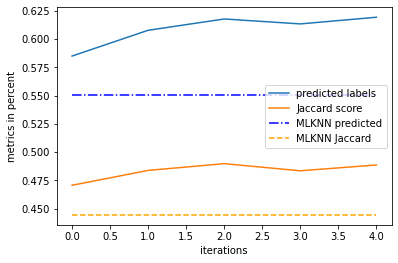

In [ ]:
plt.figure()
# plt.plot(met1list)
plt.plot(met2list)
plt.plot(jaclist)
# plt.hlines(y=[mlknn_met1], xmin = 0, xmax = 4, colors=['blue'], linestyles=['--'])
plt.hlines(y=[mlknn_met2], xmin = 0, xmax = 4, colors=['blue'], linestyles=['-.'])
plt.hlines(y=[mlknn_jac], xmin = 0, xmax = 4, colors=['orange'], linestyles=['--'])

plt.legend(['predicted labels', 'Jaccard score','MLKNN predicted', 'MLKNN Jaccard'], loc = 'best')
plt.ylabel('metrics in percent')
plt.xlabel('iterations')
plt.show()